In [1]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pip install geopandas
import geopandas as gpd
%pip install pgeocode
import pgeocode
%pip install geopy
from geopy.geocoders import Nominatim
import pgeocode
%pip install plotly
import plotly.graph_objects as go

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Center For Community Service
#### Project: Data Analysis on E-bike Survey Collected on 04/29/2023

## Supporting Datasets

##### CSV: San Diego Per Capita Income by Zipcode
###### Reference: 
- San Diego Per Capita Income by Zip Code
    - URL: https://zipatlas.com/us/ca/san-diego/zip-code-comparison/highest-per-capita-income.htm
- Social Explorer
    - URL: https://www.socialexplorer.com/profiles/essential-report/92114-zcta5.html
- Government Census Data
    - URL: https://data.census.gov/

In [2]:
# Read csv file
sd_income = pd.read_csv("SD_Income_Zipcode.csv")
sd_income.head()

,zipcode,income
0,92145,72060
1,92130,71263
2,92101,63001
3,92106,60984
4,92103,60318


## Part I: Data Cleaning

##### CSV File 1: 4.29.2023_Survey_Results.csv

In [3]:
# Read survey data from the csv file
df = pd.read_csv("4.29.2023_Survey_Results.csv")

In [4]:
# Keep numerical and binary columns
quant_df = df.drop("Who took this survey (initials)", axis=1)
quant_df.drop("Any additional comments?", axis=1, inplace=True)
quant_df.drop("Who's survey is this?", axis=1, inplace=True)
quant_df.drop("Timestamp", axis=1, inplace=True)
quant_df.drop("Unnamed: 16", axis=1, inplace=True)

# Change headers
quant_df.columns = ['bike_rider', 'zipcode', 'ebike_rider', 'commute_purpose',
                   'miles', 'try_bike', 'ebike_class', 'private_locker', 'group_locker',
                   'ebike_rules', 'safty', 'interested']

In [5]:
# convert zipcode values to string
quant_df['zipcode'] = quant_df['zipcode'].apply(lambda x: str(x).replace('.0', ''))

# convert all letters to lowercase
columns = quant_df.columns
for column in columns:
    quant_df[column] = quant_df[column].str.lower()

In [6]:
# Set cells to null if its unit is time
quant_df['miles'] = quant_df['miles'].apply(lambda x: np.nan if pd.isnull(x) or 'min' in x else x)
quant_df['miles'] = quant_df['miles'].str.extract(r'(\d+)', expand=False).astype(float).astype(pd.Int64Dtype())

##### CSV File 2: 6.08.2023_Online_Survey_Results.csv

In [7]:
df2= pd.read_csv("6.08.2023_Online_Survey_Results.csv")

In [8]:
# Keep question columns only
df2 = df2[['Q1', 'Q2', 'Q3',
           'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 
           'Q4_5', 'Q4_6', 'Q4_7', 'Q5', 'Q6',
           'Q7', 'Q8', 'Q9', 'Q10', 'Q11']]

# Drop row 1
df2 = df2.drop(1)

In [9]:
# Change column names
df2.columns = ['bike_rider', 'zipcode', 'ebike_rider', 'commute_purpose_1', 'commute_purpose_2',
               'commute_purpose_3', 'commute_purpose_4', 'commute_purpose_5', 'commute_purpose_6',
               'commute_purpose_7', 'miles', 'try_bike', 'ebike_class', 'locker',
               'ebike_rules', 'safty', 'interested']
df2 = df2.drop(0)

In [10]:
# Set cells to null if its unit is time
df2['miles'] = df2['miles'].apply(lambda x: np.nan if pd.isnull(x) or 'min' in x else x)
df2['miles'] = df2['miles'].str.extract(r'(\d+)', expand=False).astype(float).astype(pd.Int64Dtype())

In [11]:
# Keep U.S. zipcodes only
df2['zipcode'] = df2['zipcode'].apply(lambda x: np.nan if pd.isnull(x) or len(x) != 5 else x)

##### Merge quant_df Dataframe and df2 Dataframe

In [12]:
# Combine two dataframes
df = pd.concat([quant_df, df2], ignore_index=True)

# Convert all letters to lowercase
columns = df.columns
for column in columns:
    if column != 'zipcode' and column != 'miles':
        df[column] = df[column].str.lower()

# Drop the column for 'combination' among communte_purpose
df = df.drop('commute_purpose_6', axis=1)

In [13]:
# Convert all columns except for 'miles' and 'zipcode' to string
columns = df.columns
for column in columns:
    if column != 'zipcode' and column != 'miles':
        df[column] = df[column].astype(str)

# Rename each commute purpose columns
df = df.rename(columns={'commute_purpose_1': 'by_public', 
                        'commute_purpose_2': 'by_car',
                        'commute_purpose_3': 'by_bike',
                        'commute_purpose_4': 'by_ebike',
                        'commute_purpose_5': 'by_walking',
                        'commute_purpose_7': 'no_commute'})

In [14]:
# Transfer information in 'commute_purpose' column in to 'by_' columns
df['by_public'] = df.apply(lambda row: 1 if 'public' in row['commute_purpose']
                                                          or 'trolley' in row['commute_purpose'] 
                                                          or 'mts' in row['commute_purpose'] 
                                                          or 'bus' in row['commute_purpose']
                                          else row['by_public'], axis=1)

df['by_car'] = df.apply(lambda row: 1 if 'car' in row['commute_purpose'] or 'uber' in row['commute_purpose'] 
                                      else row['by_car'], axis=1)
df['by_bike'] = df.apply(lambda row: 1 if 'bike' in row['commute_purpose'] and 'e bike' not in row['commute_purpose']
                                       else row['by_bike'], axis=1)
df['by_ebike'] = df.apply(lambda row: 1 if 'e bike' in row['commute_purpose']
                                       else row['by_ebike'], axis=1)
df['by_walking'] = df.apply(lambda row: 1 if 'walk' in row['commute_purpose']
                                       else row['by_walking'], axis=1)
df['no_commute'] = df.apply(lambda row: 1 if 'i do not commute' in row['commute_purpose']
                                       else row['no_commute'], axis=1)

# Convert value in 'by_' columns to 1 if the cell != nan
df['by_public'] = df['by_public'].apply(lambda x: 1 if x != 'nan' else 0)
df['by_car'] = df['by_car'].apply(lambda x: 1 if x != 'nan' else 0)
df['by_bike'] = df['by_bike'].apply(lambda x: 1 if x != 'nan' else 0)
df['by_ebike'] = df['by_ebike'].apply(lambda x: 1 if x != 'nan' else 0)
df['by_walking'] = df['by_walking'].apply(lambda x: 1 if x != 'nan' else 0)
df['no_commute'] = df['no_commute'].apply(lambda x: 1 if x != 'nan' else 0)

# Drop 'commute_purpose' column since it's been one-hot encoded into 'by_' columns
df = df.drop('commute_purpose', axis=1)

In [15]:
# Keep answersin the 'ebike_rider' column to either yes or no
df['ebike_rider'] = df['ebike_rider'].apply(lambda x: 'yes' if x != 'nan' and x != 'no' else x)

In [16]:
# Reorder the columns to make it align with the order of the survey questions
df = df[['bike_rider', 'zipcode', 'ebike_rider',
         'by_public', 'by_car', 'by_bike', 'by_ebike', 'by_walking', 'no_commute',
         'miles', 'try_bike', 'ebike_class', 'private_locker', 'group_locker', 'locker',
         'ebike_rules', 'safty', 'interested']]

In [17]:
# Save df as quant_df, which is the name of the df that will be used in the analysis
quant_df = df

##### CSV File 3: June_10_2023_Survey_Data.csv

In [18]:
df3 = pd.read_csv('June_10_2023_Survey_Data.csv')

In [19]:
concatenated_df = pd.concat([quant_df, df3], sort=False)

# Reset the index of the concatenated dataframe
concatenated_df = concatenated_df.reindex(columns=df.columns)

In [20]:
def replace_with_yes(row):
    if type(row) != float:
        if 'yes' in row:
            return 'yes'
    return row

def replace_with_no(row):
    if type(row) != float:
        if 'no' in row or 'but' in row:
            return 'no'
    return row

def replace_with_maybe(row):
    if type(row) != float:
        if 'may' in row:
            return 'maybe'
    return row

def replace_with_dn(row):
    if type(row) != float:
        if "don't know" in row or 'don’t know' in row:
            return 'don\'t know'
    return row

def replace_with_nan(row):
    if type(row) != float:
        if 'nan' in row:
            return np.nan
    return row

def replace_with_depends(row):
    if type(row) != float:
        if 'depends' in row:
            return 'somewhat'
    return row

In [21]:
concatenated_df['bike_rider'] = concatenated_df['bike_rider'].apply(replace_with_yes)
concatenated_df['bike_rider'] =concatenated_df['bike_rider'].apply(replace_with_no)

In [22]:
concatenated_df['ebike_rules'] = concatenated_df['ebike_rules'].apply(replace_with_dn)

In [23]:
# convert zipcode values to string
concatenated_df['zipcode'] = concatenated_df['zipcode'].apply(lambda x: str(x).replace('.0', ''))

In [24]:
concatenated_df['try_bike'] = concatenated_df['try_bike'].apply(replace_with_nan)
concatenated_df['private_locker'] = concatenated_df['private_locker'].apply(replace_with_nan)
concatenated_df['group_locker'] = concatenated_df['group_locker'].apply(replace_with_nan)
concatenated_df['group_locker'] = concatenated_df['group_locker'].apply(replace_with_depends)
concatenated_df['locker'] = concatenated_df['locker'].apply(replace_with_nan)
concatenated_df['safty'] = concatenated_df['safty'].apply(replace_with_nan)
concatenated_df['interested'] = concatenated_df['interested'].apply(replace_with_nan)
concatenated_df['interested'] = concatenated_df['interested'].apply(replace_with_no)
concatenated_df['interested'] = concatenated_df['interested'].apply(replace_with_yes)
concatenated_df['interested'] = concatenated_df['interested'].apply(replace_with_maybe)

In [25]:
concatenated_df

,bike_rider,zipcode,ebike_rider,by_public,by_car,by_bike,by_ebike,by_walking,no_commute,miles,try_bike,ebike_class,private_locker,group_locker,locker,ebike_rules,safty,interested
0,no,92115,no,0,0,0.0,0,0,1,<NA>,maybe,no,very,very,NaN,don't know,not very,no
1,no,92129,no,0,1,0.0,0,0,0,<NA>,no,a bit,NaN,NaN,NaN,not very,somewhat,no
2,no,92115,yes,1,0,0.0,0,0,0,1,maybe,a bit,very,somewhat,NaN,don't know,very,yes
3,no,92562,no,0,0,0.0,0,0,1,<NA>,NaN,no,NaN,NaN,NaN,don't know,not concerned,maybe
4,yes,92109,no,0,0,0.0,0,0,1,<NA>,NaN,no,NaN,NaN,NaN,don't know,not concerned,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,no,91945,no,0,1,NaN,0,0,0,20,NaN,a bit,NaN,NaN,somewhat,not very,NaN,yes
37,yes,92108,no,0,1,NaN,0,0,0,10,NaN,no,NaN,NaN,somewhat,not very,NaN,yes
38,yes,92117,no,0,1,NaN,0,0,0,15,NaN,no,NaN,NaN,very,not very,NaN,maybe
39,yes,92102,no,0,1,NaN,0,0,0,12,NaN,no,NaN,NaN,somewhat,somewhat,NaN,maybe


Here's a description of each feature (column) in the quant_df DataFrame:

Header | Description
-------|------------
bike_rider | Are you a bike rider?
zipcode | What is your zip code?
ebike_rider | Do you or anyone in your family ride an e-bike?
by_public | How do you commute - to work, school, or for other purposes? - Answered by public transportaion
by_car | How do you commute - to work, school, or for other purposes? - Answered by car
by_bike | How do you commute - to work, school, or for other purposes? - Answered by bike
by_ebike | How do you commute - to work, school, or for other purposes? - Answered by e bike
by_walking | How do you commute - to work, school, or for other purposes? - Answered by walking
no_commute | How do you commute - to work, school, or for other purposes? - Answered no need for commute
miles | How far (ROUND TRIP) do you commute for any purpose each day?
try_bike | Would you commute by e-bike if given the opportunity?
ebike_class | Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?
private_locker | How comfortable would you be storing your bike in a private bike locker while you are commuting?
group_locker | How comfortable would you be storing your bike in a group bike locker while you are commuting?
locker | How comfortable would you be storing your bike in a bike locker while you are commuting?
ebike_rules | How familiar are you and those in your family with the rules of the road for e-bikes?
safty | How concerned are you about e-bikes and e-bike safety in San Diego County?
interested | Are you interested in learning more about e-bikes?


#### Export Data Frame as Excel

In [48]:
# Export DataFrame to Excel
excel_filename = 'cce_survey_data.xlsx'
concatenated_df.to_excel(excel_filename, index=False)

## Part II: Analysis on Numerical and Categorical Features

#### Survey Question: Are you a bike rider? | Column: bike_rider

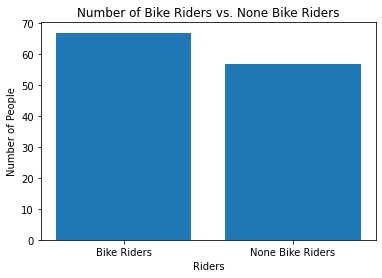

54% of the participants are bike riders
46% of the participants are NOT bike riders


In [26]:
# count number of bike rider and non-bike rider
bike_rider_count = quant_df['bike_rider'].value_counts()
bike_rider_yes = bike_rider_count[0] + bike_rider_count[2] + bike_rider_count[4]
bike_rider_no = bike_rider_count[1] + bike_rider_count[3]

# create bar plot
x = ['Bike Riders', 'None Bike Riders']
y = [bike_rider_yes, bike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of Bike Riders vs. None Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
bike_percent_yes = round(bike_rider_yes / (bike_rider_yes + bike_rider_no) * 100)
bike_percent_no = round(bike_rider_no / (bike_rider_no + bike_rider_yes) * 100)
print(f'{bike_percent_yes}% of the participants are bike riders')
print(f'{bike_percent_no}% of the participants are NOT bike riders')

#### Survey Question: What is your zip code? | Column: zipcode

In [27]:
# Create a dataframe for zipcode counts
zipcode_count = quant_df[['zipcode']].dropna()
zipcode_count['count'] = 1
zipcode_df = zipcode_count.groupby('zipcode').sum().reset_index()
zipcode_df = zipcode_df[zipcode_df['zipcode'] != 'nan']

In [28]:
# Convert zipcode to longitude and latitude
def convert_zipcodes_to_coordinates(zipcodes):
    geolocator = Nominatim(user_agent="zipcode_converter")
    coordinates = []
    for zipcode in zipcodes:
        location = geolocator.geocode(zipcode)
        if location:
            coordinates.append((location.latitude, location.longitude))
        else:
            coordinates.append((None, None))
    return coordinates


zipcode_df[['Latitude', 'Longitude']] = pd.DataFrame(convert_zipcodes_to_coordinates(zipcode_df['zipcode']))

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=05753&format=json&limit=1 (Caused by ProxyError('Cannot connect to proxy.', timeout('_ssl.c:1106: The handshake operation timed out')))

In [ ]:
zipcode_df

In [ ]:
# Plot zipcode distribution of datapoints
nomi = pgeocode.Nominatim('us')

zipcode_df['Latitude'] = (nomi.query_postal_code(zipcode_df['zipcode'].tolist()).latitude)
zipcode_df['Longitude'] = (nomi.query_postal_code(zipcode_df['zipcode'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = zipcode_df['Longitude'],
        lat = zipcode_df['Latitude'],
        mode = 'markers',
        marker_color = zipcode_df['count'],
        ))

fig.update_layout(
        title = 'Zipcode Distribution',
        geo_scope='usa',
    )

fig.show()

#### Survey Question: Are you a ebike_rider? | Column: ebike_rider

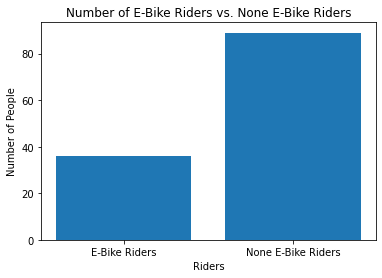

29% of the participants are e-bike riders
71% of the participants are NOT e-bike riders


In [29]:
# count number of ebike rider vs. non-ebike rider
ebike_rider_no = quant_df[quant_df['ebike_rider'] == 'no'].shape[0]
ebike_rider_yes = quant_df.shape[0] - ebike_rider_no

# create bar plot
x = ['E-Bike Riders', 'None E-Bike Riders']
y = [ebike_rider_yes, ebike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of E-Bike Riders vs. None E-Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
ebike_percent_yes = round(ebike_rider_yes / (ebike_rider_yes + ebike_rider_no) * 100)
ebike_percent_no = round(ebike_rider_no / (ebike_rider_no + ebike_rider_yes) * 100)
print(f'{ebike_percent_yes}% of the participants are e-bike riders')
print(f'{ebike_percent_no}% of the participants are NOT e-bike riders')

#### Survey Question: How do you commute - to work, school, or for other purposes? | Column: by_ ..., no_commute

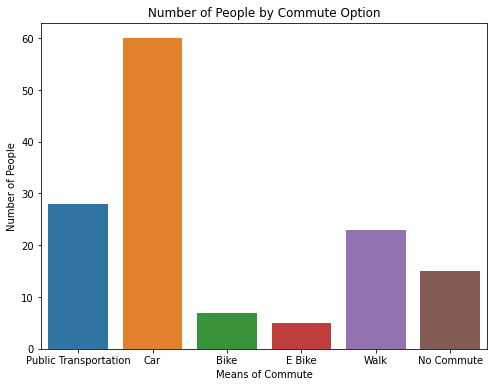

In [30]:
# Enter Code Here
x_values = ['Public Transportation', 'Car', 'Bike', 'E Bike', 'Walk', 'No Commute']

y_values = [df['by_public'].sum(), df['by_car'].sum(),
     df['by_bike'].sum(), df['by_ebike'].sum(),
     df['by_walking'].sum(), df['no_commute'].sum()]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=x_values, y=y_values)
plt.xlabel('Means of Commute')
plt.ylabel('Number of People')
plt.title('Number of People by Commute Option')
plt.show()

#### Survey Question: How far (ROUND TRIP) do you commute for any purpose each day? | Column: miles

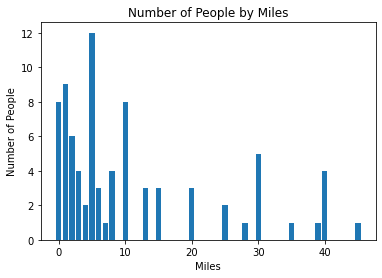

In [31]:
# count number of miles
miles_count = quant_df['miles'].value_counts()

# create bar plot
x = miles_count.index
y = miles_count.values
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Miles')
plt.ylabel('Number of People')
plt.title('Number of People by Miles')

# display the plot
plt.show()

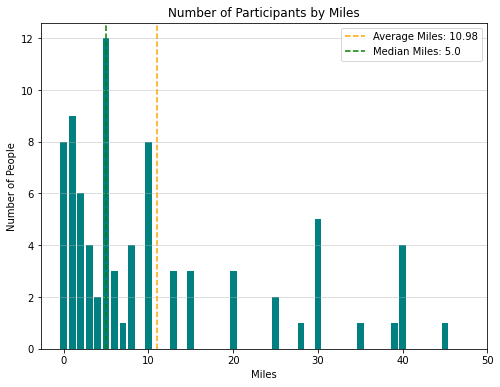

In [32]:
# count number of miles
mile_counts = quant_df['miles'].value_counts(sort = False)

# create bar plot
fig, ax = plt.subplots(figsize = (8, 6))
bars = ax.bar(mile_counts.index, mile_counts.values, color = 'teal')
ax.set_xlabel('Miles')
ax.set_ylabel('Number of People')
ax.set_title('Number of Participants by Miles')

# add a vertical line to show the average and median miles
ax.grid(axis = 'y', alpha = 0.5)
avg_miles = quant_df['miles'].mean()
med_miles = quant_df['miles'].median()
ax.axvline(x = avg_miles, color = 'orange', linestyle = '--', label = f'Average Miles: {avg_miles:.2f}')
ax.axvline(x = med_miles, color = 'green', linestyle = '--', label = f'Median Miles: {med_miles}')
ax.set_xticks(range(0, 51, 10))

# show the plot
ax.legend()
plt.show()

#### Survey Question: Would you commute by e-bike if given the opportunity? | Column: try_bike

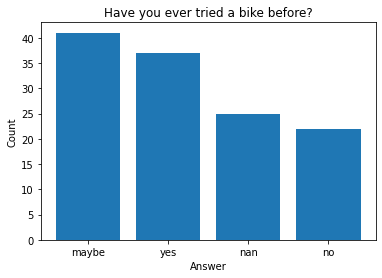

In [33]:
# Count the number of occurrences of each unique value in the try_bike column
try_bike_counts = quant_df['try_bike'].value_counts()

# Create a bar plot
plt.bar(try_bike_counts.index, try_bike_counts.values)

# Set the title and axis labels
plt.title('Have you ever tried a bike before?')
plt.xlabel('Answer')
plt.ylabel('Count')

# Show the plot
plt.show()

#### Survey Question: Do you know the differences between Class 1, Class 1, and Class 3 e-bikes? | Column: ebike_class

Text(0, 0.5, 'Count')

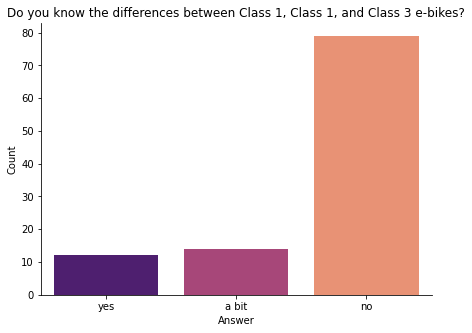

In [34]:
# Count the number of occurrences of each unique value in the ebike_class column
ebike_class_count = quant_df['ebike_class'].value_counts()

# Create a bar graph
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=ebike_class_count.index, y = ebike_class_count.values, palette='magma', order = ['yes', 'a bit', 'no'])

# Set title and labels to the graph
plt.title('Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')


#### Survey Question: How comfortable would you be storing your bike in a private bike locker while you are commuting? | Column: private_locker

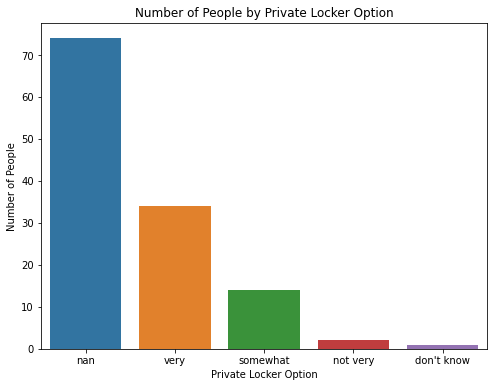

In [35]:
# Count the occurrences of each option in the 'private_locker' column
private_locker_counts = quant_df['private_locker'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=private_locker_counts.index, y=private_locker_counts.values)
plt.xlabel('Private Locker Option')
plt.ylabel('Number of People')
plt.title('Number of People by Private Locker Option')
plt.show()

#### Survey Question: How comfortable would you be storing your bike in a group bike locker while you are commuting? | Column: group_locker

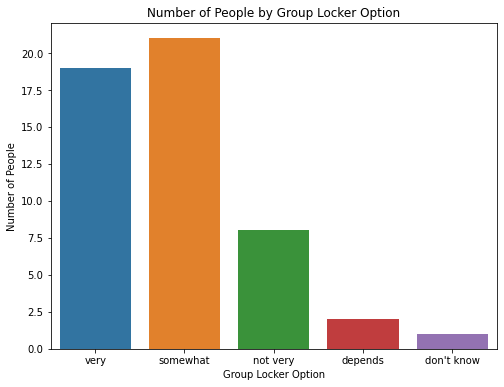

In [36]:
category_order = ['very', 'somewhat', 'not very', 'depends', "don't know"]
quant_df['group_locker'] = pd.Categorical(quant_df['group_locker'], categories=category_order, ordered=True)
group_locker_counts = quant_df['group_locker'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=group_locker_counts.index, y=group_locker_counts.values)
plt.xlabel('Group Locker Option')
plt.ylabel('Number of People')
plt.title('Number of People by Group Locker Option')
plt.show()

#### Survey Question: How familiar are you and those in your family with the rules of the road for e-bikes? | Column: ebike_rules

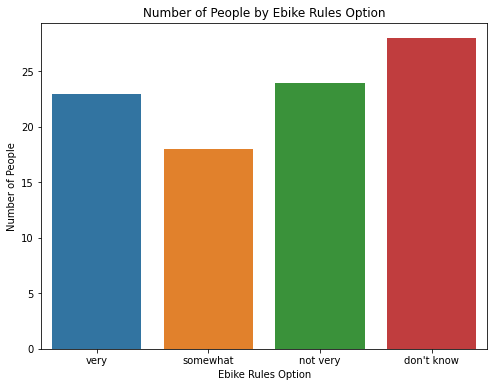

In [37]:
order = ['very', 'somewhat', 'not very', "don't know"]
ebike_rules_counts = quant_df['ebike_rules'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=ebike_rules_counts.index, y=ebike_rules_counts.values, order=order)
plt.xlabel('Ebike Rules Option')
plt.ylabel('Number of People')
plt.title('Number of People by Ebike Rules Option')
plt.show()

#### Survey Question: How concerned are you about e-bikes and e-bike safety in San Diego County? | Column: safty

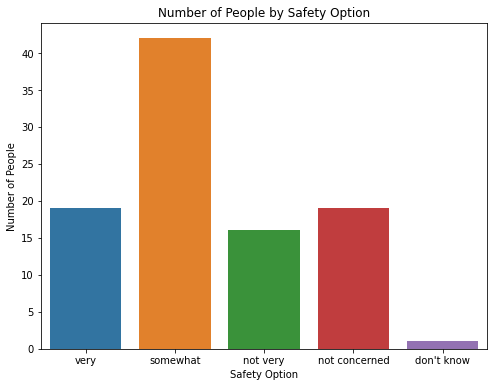

In [38]:
order = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]
safety_counts = quant_df['safty'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=safety_counts.index, y=safety_counts.values, order=order)
plt.xlabel('Safety Option')
plt.ylabel('Number of People')
plt.title('Number of People by Safety Option')
plt.show()

#### Survey Question: Are you interested in learning more about e-bikes? | Column: interested

Text(0, 0.5, 'Count')

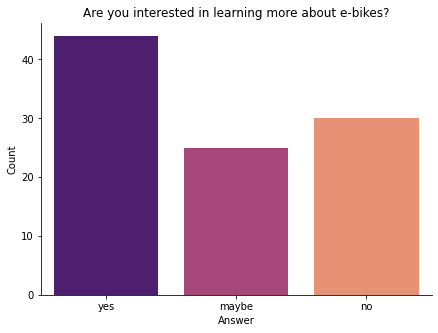

In [39]:
# Fix typo and category in answers
quant_df['interested'] = quant_df['interested'].str.strip()
quant_df['interested'] = quant_df['interested'].str.replace('may be', 'maybe')
quant_df['interested'] = quant_df['interested'].str.replace('already know', 'yes')
quant_df['interested'] = quant_df['interested'].str.replace('knows enough', 'yes')

# Count the number of occurrences of each unique value in the interested column
interested_count = quant_df['interested'].value_counts()

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=interested_count.index, y = interested_count.values, palette='magma', order = ['yes', 'maybe', 'no'])

# Set title and labels to the graph
plt.title('Are you interested in learning more about e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')

## Part III: Correlation Analysis

### bike_rider vs. ibike_rider, persentage show by text

In [ ]:
correlation = quant_df['bike_rider'].eq('yes').astype(int).corr(quant_df['ebike_rider'].eq('yes').astype(int))

yes_yes_count = quant_df[(quant_df['bike_rider'] == 'yes') & (quant_df['ebike_rider'] == 'yes')].shape[0]
yes_no_count = quant_df[(quant_df['bike_rider'] == 'yes') & (quant_df['ebike_rider'] == 'no')].shape[0]
no_yes_count = quant_df[(quant_df['bike_rider'] == 'no') & (quant_df['ebike_rider'] == 'yes')].shape[0]
no_no_count = quant_df[(quant_df['bike_rider'] == 'no') & (quant_df['ebike_rider'] == 'no')].shape[0]

total_count = len(quant_df)

yes_yes_percent = round((yes_yes_count / total_count) * 100, 2)
yes_no_percent = round((yes_no_count / total_count) * 100, 2)
no_yes_percent = round((no_yes_count / total_count) * 100, 2)
no_no_percent = round((no_no_count / total_count) * 100, 2)

data = [[yes_yes_percent, yes_no_percent], [no_yes_percent, no_no_percent]]

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(data, cmap='YlOrBr', annot=True, fmt=".2f", cbar=True, linewidths=0.5)

ax.set_xticklabels(['ebike_rider: Yes', 'ebike_rider: No'])
ax.set_yticklabels(['bike_rider: Yes', 'bike_rider: No'])

ax.set_xlabel('ebike_rider')
ax.set_ylabel('bike_rider')
ax.set_title('Percentage of Participants')

plt.tight_layout()
plt.show()

### bike rider vs. miles, bar graph

### ebike_rules vs. safety, persentage by text

In [ ]:
ebike_rules_categories = ['very', 'somewhat', 'not very', "don't know"]
safety_categories = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]

percentages = []
for ebike_rule in ebike_rules_categories:
    row = []
    for safety in safety_categories:
        count = quant_df[(quant_df['ebike_rules'] == ebike_rule) & (quant_df['safty'] == safety)].shape[0]
        percent = round((count / total_count) * 100, 2)
        row.append(percent)
    percentages.append(row)

data = percentages

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data, cmap='YlOrBr', annot=True, fmt=".2f", cbar=True, linewidths=0.5)

ax.set_xticklabels(safety_categories)
ax.set_yticklabels(ebike_rules_categories)

ax.set_xlabel('Safety')
ax.set_ylabel('ebike_rules')
ax.set_title('Percentage of Participants')

plt.tight_layout()
plt.show()

### ebike_rules vs. safety, persentage by heatmap

In [ ]:
#heatmap
import matplotlib.patheffects as path_effects
safety_categories = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]
ebike_rules_categories = ['very', 'somewhat', 'not very', "don't know"]

percentages = []
for safety in safety_categories:
    row = []
    for ebike_rule in ebike_rules_categories:
        count = quant_df[(quant_df['safty'] == safety) & (quant_df['ebike_rules'] == ebike_rule)].shape[0]
        percentage = (count / total_count) * 100
        row.append(percentage)
    percentages.append(row)

percentages = np.array(percentages)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(percentages, cmap='YlOrBr', annot=True, fmt=".1f", cbar=True, linewidths=0.5)

ax.set_xticks(np.arange(len(ebike_rules_categories)))
ax.set_yticks(np.arange(len(safety_categories)))
ax.set_xticklabels(ebike_rules_categories)
ax.set_yticklabels(safety_categories)

ax.set_xlabel('eBike Rules')
ax.set_ylabel('Safety Response')
ax.set_title('Percentage of Safety Responses by eBike Rules')

plt.tight_layout()
plt.show()

### private_locker vs. group_locker, persentage by heatmap

In [ ]:
#heatmap
import seaborn as sns

private_locker_categories = ['very', 'somewhat', 'not very', "don't know"]
group_locker_categories = ['very', 'somewhat', 'not very', 'depends', "don't know"]

percentages = []
for private_locker in private_locker_categories:
    row = []
    for group_locker in group_locker_categories:
        count = quant_df[(quant_df['private_locker'] == private_locker) & (quant_df['group_locker'] == group_locker)].shape[0]
        percentage = (count / total_count) * 100
        row.append(percentage)
    percentages.append(row)

percentages = np.array(percentages)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(percentages, cmap='YlOrBr', annot=True, fmt=".1f", cbar=True, linewidths=0.5)

ax.set_xticks(np.arange(len(group_locker_categories)) + 0.5)
ax.set_yticks(np.arange(len(private_locker_categories)) + 0.5)
ax.set_xticklabels(group_locker_categories)
ax.set_yticklabels(private_locker_categories)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

ax.set_xlabel('Group Locker')
ax.set_ylabel('Private Locker')
ax.set_title('Percentage of Private Locker vs Group Locker')

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
geolocator = Nominatim(user_agent='myGeocoder')
df['location'] = df['zipcode'].apply(lambda x: geolocator.geocode(x) if pd.notnull(x) else None)
df['latitude'] = df['location'].apply(lambda loc: loc.latitude if loc else None)
df['longitude'] = df['location'].apply(lambda loc: loc.longitude if loc else None)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
fig = px.scatter_mapbox(gdf, lat='latitude', lon='longitude', color='try_bike',
                        color_discrete_map={'yes': 'green', 'no': 'red'},
                        zoom=10, height=500)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(title='Map of "try_bike" Responses')
fig.show()

## Part IV: An Unsupervised Machine Learning to Cluster San Diego Zipcode by Demographic Features

#### Setup

In [ ]:
%pip install scikit-learn
from sklearn.cluster import KMeans